lets load the model for the pretrained vit based on the following [paper](https://arxiv.org/abs/2010.11929)

In [ ]:
!pip install pytorch_pretrained_vit
from pytorch_pretrained_vit import ViT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_pretrained_vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11116 sha256=491b4ed0d965ff2e0217581630cfd38c03fe29b4e1bb3ebd3e78433cd51b8a1e
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch_pretrained_vit


load all the packages required for the study

In [ ]:
import os
import math
import numpy
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
#%matplotlib inline

import gc

from torch.optim.lr_scheduler import StepLR

import torchvision.transforms as T
import torchvision.transforms.functional as TF

from torchvision.models.vision_transformer import VisionTransformer

from pytorch_pretrained_vit import ViT

mount the drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The line of code `torch.manual_seed(20)` sets the random seed for the torch module to ensure reproducibility.

In [ ]:
torch.manual_seed(20)

check gpu availability

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


set the training and testing directory

In [ ]:
# Directory Names
dir_training = '/content/drive/MyDrive/EDA_jaw_scanner/training'
dir_testing = '/content/drive/MyDrive/EDA_jaw_scanner/testing'

The code defines a custom dataset class called `jawdataset` for loading and processing data. It takes a directory path `img_dir` and an optional data transformation function `transform`. The `__len__` method returns the total number of data files in the directory. The `__getitem__` method retrieves a data sample at a specific index `idx`. It loads a numpy array from the corresponding file, removes some elements, reshapes it, and converts it to a PyTorch tensor. It also determines the label based on the file name and returns the tensor data and label as a tuple. Optional data transformations can be applied.

In [ ]:
class jawdataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.dataset_path = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.dataset_path))

    def __getitem__(self, idx):
        if idx >= len(os.listdir(self.dataset_path)):
            print("No datafile/image at index: " + str(idx))
            return None
        
        npy_filename = os.listdir(self.dataset_path)[idx]
        label = int('lower jaw' not in npy_filename)
        
        numpy_arr = numpy.load(os.path.join(self.dataset_path, npy_filename))
        for i in range(numpy_arr.shape[0] - 70):
            numpy_arr = numpy.delete(numpy_arr, [0], axis=0)
        numpy_arr = numpy_arr.reshape(1, 70, 70, 70)
        tensor_arr = torch.from_numpy(numpy_arr).to(torch.float32)

        del numpy_arr
        gc.collect()

        if self.transform:
            tensor_arr = self.transform(tensor_arr)

        return tensor_arr.to(torch.float32), torch.LongTensor([label])



check the labels of the data

In [ ]:
dataset = jawdataset(dir_training)  # Replace `img_dir` with the actual directory path

# Iterate over the dataset and print the labels
for i in range(len(dataset)):
    data, label = dataset[i]
    if label.item() == 0:
        print(f"Sample {i}: lower jaw")
    elif label.item() == 1:
        print(f"Sample {i}: upper jaw")
    else:
        print(f"Sample {i}: Unknown label")


Sample 0: upper jaw
Sample 1: upper jaw
Sample 2: upper jaw
Sample 3: upper jaw
Sample 4: upper jaw
Sample 5: upper jaw
Sample 6: upper jaw
Sample 7: upper jaw
Sample 8: upper jaw
Sample 9: upper jaw
Sample 10: upper jaw
Sample 11: upper jaw
Sample 12: upper jaw
Sample 13: upper jaw
Sample 14: upper jaw
Sample 15: upper jaw
Sample 16: upper jaw
Sample 17: upper jaw
Sample 18: upper jaw
Sample 19: upper jaw
Sample 20: upper jaw
Sample 21: upper jaw
Sample 22: upper jaw
Sample 23: upper jaw
Sample 24: upper jaw
Sample 25: upper jaw
Sample 26: upper jaw
Sample 27: lower jaw
Sample 28: lower jaw
Sample 29: lower jaw
Sample 30: lower jaw
Sample 31: lower jaw
Sample 32: lower jaw
Sample 33: lower jaw
Sample 34: lower jaw
Sample 35: lower jaw
Sample 36: lower jaw
Sample 37: lower jaw
Sample 38: lower jaw
Sample 39: lower jaw
Sample 40: lower jaw
Sample 41: lower jaw
Sample 42: lower jaw
Sample 43: lower jaw
Sample 44: lower jaw
Sample 45: lower jaw
Sample 46: lower jaw
Sample 47: lower jaw
Sa

augmentation

In [ ]:
data_augmentation_transformations = T.Compose([ # Geometric Transformation
    # T.RandomAffine(degrees=(-90, 90), scale=(0.7,1), translate=(0, 0.2)), 
    T.RandomHorizontalFlip(), # Reflect
    T.RandomChoice([
      T.RandomAffine(degrees=0), # No Transformation
      T.Compose([T.RandomErasing(p=1, scale=(0.0008, 0.0008), ratio=(1,1))]*200), # Occlusion
    ]),
])  

loaded the training and validation data

In [ ]:
training_data = jawdataset(img_dir=dir_training, transform=None)
validation_data = jawdataset(img_dir=dir_testing, transform=None)

checking whether the data has been loaded properly or is it just empty array

In [ ]:
def check_all_zeros(array):
    all_zeros = np.allclose(array, 0)
    return all_zeros

In [ ]:
print(check_all_zeros(training_data[1][0]))

False


load the vit model

In [ ]:
pretrained_vit = ViT('B_16_imagenet1k', pretrained=True)

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:05<00:00, 65.1MB/s]


Loaded pretrained weights.


freeze the layers

In [ ]:
for param in pretrained_vit.parameters():
    param.requires_grad = False

The code defines a neural network model called `NeuralNetwork` by subclassing `nn.Module`. It consists of a series of convolutional layers, ReLU activations, and max pooling operations for feature extraction. The extracted features are then passed through a Vision Transformer (ViT) model and a fully connected layer for classification. The ViT model can be pretrained or initialized separately. The output of the model is a tensor representing the predicted class probabilities. The `forward` method defines the forward pass of the model, where the input tensor `x` is passed through the defined layers sequentially to obtain the final output. The model performs feature extraction, reshaping, and classification in its forward pass.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Flatten(),
        )

        self.vit = pretrained_vit
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.repeat(1, 36, 1, 1, 1)
        x = x.view(-1, 1, 384, 384)
        x = x.repeat(1, 3, 1, 1)
        # print(x.shape)
        x = self.vit(x)
        x = self.fc(x)
        return x

Create an instance of the `NeuralNetwork` model and move it to the specified device (e.g., GPU or CPU).

In [ ]:
model = NeuralNetwork().to(device)

In [ ]:
training_data[0][0].shape

torch.Size([1, 70, 70, 70])

In [ ]:
datax = training_data[0][0].reshape(1,1,70,70,70).to(device)

In [ ]:
model(datax)

tensor([[0.0401, 0.0103]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# Hyperparameters
epochs = 50
batch_size = 2
learning_rate = 1e-5
weight_decay = 0.0000000001
momentum=0.999999

setting the loss functions, optimizers and schedulers

In [ ]:
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( model.parameters()  ,lr=learning_rate)
# optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
training_data_loader = DataLoader(training_data, batch_size, shuffle = True)
validation_data_loader = DataLoader(validation_data, batch_size, shuffle = False)

This code defines a training function that takes a data loader, model, loss function, and optimizer as inputs. It iterates over batches of data, performs forward pass, computes the prediction error (loss), performs backpropagation to update the model's parameters, and prints the loss during training. The function ensures that the model is in training mode and moves the data and model to the specified device (e.g., GPU). The size variable represents the size of the dataset. The function aims to train the model by minimizing the loss and monitoring the progress through printed loss values.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    torch.cuda.empty_cache()
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        # pred2 = vit_model(X)
        # predLog = torch.log(pred)
        # loss = loss_fn(torch.log(pred), y.argmax(1))
        # print(y.squeeze())
        # print(pred)
        loss = loss_fn(pred, y.squeeze())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%5==0:
          # Print
          loss, current = loss.item(), batch * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

This code defines a validation function that takes a data loader, model, and loss function as inputs. It evaluates the model's performance on the validation dataset by calculating the average loss and accuracy. The function sets the model to evaluation mode and moves the data to the specified device (e.g., GPU). It iterates over batches of data, performs forward pass to get the model's predictions, calculates the loss and number of correct predictions, and accumulates the total loss and correct predictions. After processing all batches, it computes the average loss and accuracy, appends the accuracy to a list, and prints the validation results. The validation accuracy is stored in the `validation_accuracy` list for tracking the performance over time.

In [ ]:
validation_accuracy = []
def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.squeeze()).item()
            correct += (torch.argmax(pred, dim=1) == y.squeeze()).sum().item()
            X.cpu()
            y.cpu()
    test_loss /= num_batches
    correct /= size
    validation_accuracy.append(correct*100)
    # Print
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

lets train the model now!

In [ ]:
best_accuracy = 0.0
best_model_path = 'best_model.pth'

# Training
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data_loader, model, loss_function, optimizer)
    current_accuracy = validation(validation_data_loader, model, loss_function)
    
    if current_accuracy is not None and current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model with validation accuracy:", best_accuracy)
    
    # scheduler.step()

print("Done!")


Epoch 1
-------------------------------
loss: 0.695411  [    0/  102]
loss: 0.768971  [   10/  102]
loss: 0.673766  [   20/  102]
loss: 0.650111  [   30/  102]
loss: 0.963491  [   40/  102]
loss: 0.564221  [   50/  102]
loss: 0.442378  [   60/  102]
loss: 0.553991  [   70/  102]
loss: 0.797395  [   80/  102]
loss: 0.585505  [   90/  102]
loss: 0.950079  [  100/  102]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.640856 

Epoch 2
-------------------------------
loss: 0.641247  [    0/  102]
loss: 0.729236  [   10/  102]
loss: 0.512171  [   20/  102]
loss: 0.568839  [   30/  102]
loss: 0.604311  [   40/  102]
loss: 0.763612  [   50/  102]
loss: 0.327275  [   60/  102]
loss: 0.696403  [   70/  102]
loss: 0.329328  [   80/  102]
loss: 0.920738  [   90/  102]
loss: 0.625802  [  100/  102]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.448170 

Epoch 3
-------------------------------
loss: 0.562561  [    0/  102]
loss: 0.685683  [   10/  102]
loss: 0.668236  [   20/  102]
loss: 0.540350  [   30/  1

**the validation accuracy is almost always constant at a rate of 96.2%, the model seems to be quite accurate for the small data it has been tested against**

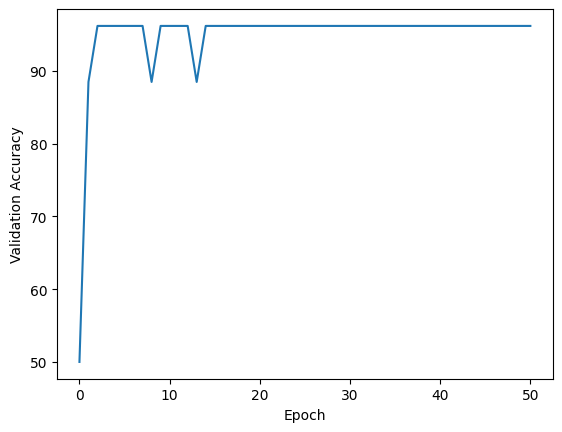

In [ ]:
plt.plot(validation_accuracy)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

plt.show()

In [ ]:
model.eval()
validation(validation_data_loader, model, loss_function)

Test Error: 
 Accuracy: 96.2%, Avg loss: 0.080635 



vary high validatio accuracy and very low loss!

In [ ]:
# Load the .npy file
preprocessed_file = np.load('/content/drive/MyDrive/EDA_jaw_scanner/evaluation/lower_jaw_lab_scanner_npy/11. Lab RMS 05 Lower jaw.npy')
reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)

with torch.no_grad():
    inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
    inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
    outputs = model(inputs)  # Forward pass to get the predicted outputs
    predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

print(predicted_label)


0


now, in the code below, we have checked the accuracy of the trained model using various scans from different machines and different operators

In [ ]:
import os

folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/upper_jaw_lab_scanner_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')


upper jaw
upper jaw
upper jaw
upper jaw
upper jaw


In [ ]:
import os

folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/lower_jaw_lab_scanner_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')

lower jaw
lower jaw
lower jaw
lower jaw
lower jaw


In [ ]:
lab_scanner = 10

In [ ]:
import os

folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/Trios_operator1_lower_jaw_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')

lower jaw
lower jaw
lower jaw
lower jaw
lower jaw


In [ ]:
import os

folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/Trios_operator1_upper_jaw_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')

upper jaw
upper jaw
upper jaw
upper jaw
upper jaw


In [ ]:
trios_op1 = 10

In [ ]:
import os

folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/Trios_operator2_lower_jaw_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')

upper jaw
lower jaw
lower jaw
lower jaw
lower jaw


In [ ]:
import os

folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/Trios_operator2_upper_jaw_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')

upper jaw
upper jaw
upper jaw
upper jaw
upper jaw


In [ ]:
trios_op2 = 9

In [ ]:
import os

folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/aor_operator1_lower_jaw_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')

lower jaw
lower jaw
lower jaw
upper jaw
upper jaw


In [ ]:
import os

folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/aor_operator1_upper_jaw_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')

upper jaw
upper jaw
upper jaw
upper jaw
upper jaw


In [ ]:
aor_op1 = 8

In [ ]:
folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/aor_operator2_upper_jaw_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')

upper jaw
upper jaw
upper jaw
upper jaw
upper jaw


In [ ]:
import os

folder_path = '/content/drive/MyDrive/EDA_jaw_scanner/evaluation/aor_operator2_lower_jaw_npy'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the .npy file
        preprocessed_file = np.load(file_path)
        reshaped_array = preprocessed_file.reshape(1, 70, 70, 70)
        
        with torch.no_grad():
            inputs = torch.from_numpy(reshaped_array).float()  # Convert the preprocessed file to a PyTorch tensor with data type float
            inputs = inputs.to(device)  # Move the tensor to the appropriate device (e.g., CPU or GPU)
            outputs = model(inputs)  # Forward pass to get the predicted outputs
            predicted_label = torch.argmax(outputs).item()  # Get the index of the predicted class label

        if predicted_label == 0:
            print('lower jaw')
        elif predicted_label == 1:
            print('upper jaw')


lower jaw
lower jaw
lower jaw
upper jaw
lower jaw


In [ ]:
aor_op2 = 9

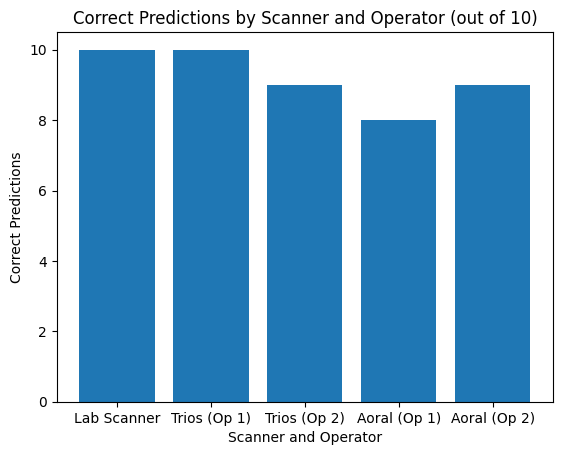

In [ ]:
import matplotlib.pyplot as plt

scanners = ['Lab Scanner', 'Trios (Op 1)', 'Trios (Op 2)', 'Aoral (Op 1)', 'Aoral (Op 2)']
predictions = [lab_scanner, trios_op1, trios_op2, aor_op1, aor_op2]

plt.bar(scanners, predictions)
plt.xlabel('Scanner and Operator')
plt.ylabel('Correct Predictions')
plt.title('Correct Predictions by Scanner and Operator (out of 10)')
plt.show()


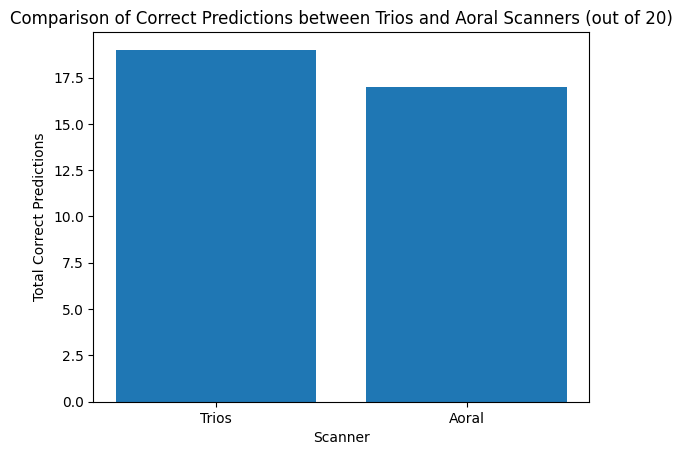

In [ ]:
import matplotlib.pyplot as plt

scanners = ['Trios', 'Aoral']
predictions = [trios_op1 + trios_op2, aor_op1 + aor_op2]

plt.bar(scanners, predictions)
plt.xlabel('Scanner')
plt.ylabel('Total Correct Predictions')
plt.title('Comparison of Correct Predictions between Trios and Aoral Scanners (out of 20)')
plt.show()


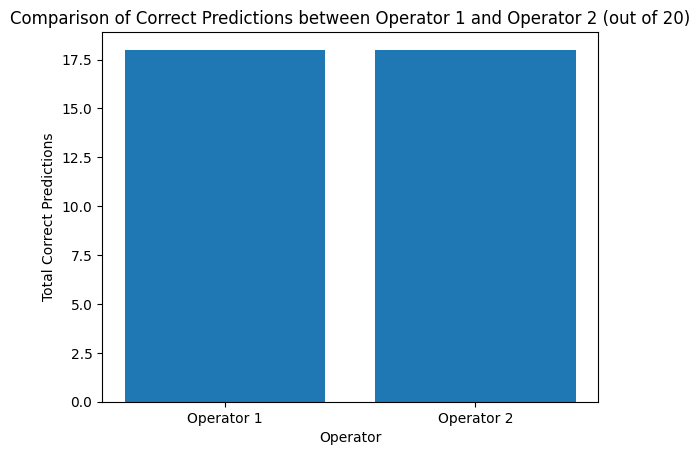

In [ ]:
import matplotlib.pyplot as plt

operators = ['Operator 1', 'Operator 2']
predictions = [trios_op1 + aor_op1, trios_op2 + aor_op2]

plt.bar(operators, predictions)
plt.xlabel('Operator')
plt.ylabel('Total Correct Predictions')
plt.title('Comparison of Correct Predictions between Operator 1 and Operator 2 (out of 20)')
plt.show()
